# GBA 6430 - Big Data Technology in Business
# Dr. Mohammad Salehan
# Machine Learning with Spark

As of Spark 2.0, the RDD-based APIs in the spark.mllib package have entered maintenance mode. The primary Machine Learning API for Spark is now the DataFrame-based API in the spark.ml package.

If you get a cell_monitor error, you can ignore it. It is a Jypyter cell error and not a Spark error.

Dataset information: Predicting forest cover type from cartographic variables.  The actual forest cover type for a given observation (30 x 30 meter cell) was determined from US Forest Service (USFS) Region 2 Resource Information System (RIS) data. <a href='https://archive.ics.uci.edu/ml/datasets/covertype'>Data Description</a>

## Loading the data

In [ ]:
import pyspark.pandas as ps
import matplotlib.pyplot as plt
ps.set_option('plotting.backend', 'matplotlib')

forest_path = 's3://cis4567-salehan/Spark/Data/forest_coverage_type.csv'
forest = ps.read_csv(forest_path)

In [ ]:
forest.shape

In [ ]:
forest.info()

In [ ]:
%%pretty
forest.to_spark().show()

## Introducing Transformers

List of the most popular **Transformers**
* Binarizer
* Bucketizer
* ChiSqSelector
* CountVectorizer
* ElementwiseProduct
* HashingTF
* IDF
* IndexToString
* MaxAbsScaler
* MinMaxScaler
* NGram
* Normalizer
* OneHotEncoder
* PCA
* QuantileDiscretizer
* RegexTokenizer
* SQLTransformer
* StandardScaler
* StopWordsRemover
* StringIndexer
* Tokenizer
* VectorAssembler
* Word2Vec

In [ ]:
import pyspark.sql.functions as F
import pyspark.ml.feature as feat
from pyspark.ml import Pipeline
import numpy as np
import pyspark.ml.classification as cl

## Principal Components Analysis
* PCA is a dimension reduction technique.
<img src='https://miro.medium.com/max/462/1*QALwLkPJG45E7_DsOccdaw.png'>
* Almost exclusively, every estimator (or, in other words, an ML model) found in the MLlib module expects to see a single column as an input; the column should contain all the features a data scientist wants such a model to use. 
* The .VectorAssembler(...) method, as the name suggests, collates multiple features into a single column.  

In [ ]:
vectorAssembler = (
    feat.VectorAssembler(
        inputCols=list(forest.columns), 
        outputCol='feat'
    )
)

norm = feat.StandardScaler(
    inputCol=vectorAssembler.getOutputCol()
    , outputCol='norm'
    , withMean=True
    , withStd=True
)

#fit PCA to the vector with 5 components
pca = (
    feat.PCA(
        k=25
        , inputCol=norm.getOutputCol()
        , outputCol='pca_feat'
    )
)

#transform the data using PCA
#original dataset contains 55 columsn
#the output shows one vectorized record as well as
#the 5 feature output of the record from PCA
pca_pipeline = Pipeline(stages=[vectorAssembler, norm, pca])
pModel = (
    pca_pipeline
    .fit(forest.to_spark())
)

(
    pModel.
    transform(forest.to_spark()).
    pandas_api()
    [['feat','pca_feat']]
    .head(1)
)

In [ ]:
print(pModel.stages[-1].explainedVariance)
print(np.cumsum(pModel.stages[-1].explainedVariance))

## Spark Estimators

List of the most popular **Estimators**
1. Classification
 * LinearSVC
 * LogisticRegression 
 * DecisionTreeClassifier
 * GBTClassifier
 * RandomForestClassifier
 * NaiveBayes
 * MultilayerPerceptronClassifier
 * OneVsRest
2. Regression
 * LinearRegression
 * GeneralizedLinearRegression
 * DecisionTreeRegressor
 * GBTRegressor
 * RandomForestRegressor
3. Clustering
 * Kmeans
 * LDA

In [ ]:
#examine all distinct values for outcome variable
forest['CoverType'].value_counts()

### Transforming the label
We transform the labels to start at zero (instead of one) otherwise classification models think there are 8 classes.

In [ ]:
forest['CoverType'] = forest['CoverType']-1
forest['CoverType'].value_counts()

## Linear Support Vector Machine (SVM)
* SVM is a classification and regression technique that tries to separate the two classes using a hyperplane. 
* SVM algorithm finds the points closest to the line from both the classes.These points are called support vectors. 
* Then, it compute the distance between the line and the support vectors. This distance is called the margin. 
* The goal is to maximize the margin. 
* Watch <a href='https://www.youtube.com/watch?v=Y6RRHw9uN9o'>this video </a> to learn more about SVM.  
<center><img src='https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/SVM_margin.png/300px-SVM_margin.png'></center>

In [ ]:
#create a vector of all variables except for the dependent variable
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features')

#We will predict the forest cover type equal to 1, that is, 
#whether the forest is a spruce-fir type; we achieve this by 
#checking whether CoverType is equal to 1 and 
#casting the resulting Boolean to an integer (0: false, 1: true)
fir_dataset = (
    vectorAssembler
    .transform(forest.to_spark())
    .pandas_api()
    .assign(label=(lambda x: (x['CoverType']==0).astype('int')))
    [['label', 'features']]
)

fir_dataset.head(1)

In [ ]:
#create a SVM object and fit to data
#the default value of label coulmn is label
#regParam is regularization parameter. In this case it will be L2
svc_obj = cl.LinearSVC(maxIter=10, regParam=0.01)
svc_model = svc_obj.fit(fir_dataset.to_spark())

#examine the model coefficients. SVM is a linear model.
svc_model.coefficients

## Linear Regression
In MLlib, we implement popular linear methods such as logistic regression and linear least squares with L1 or L2 regularization. In spark.ml, we also include Pipelines API for Elastic net, a hybrid of L1 and L2 regularization via the elastic net. Mathematically, it is defined as a convex combination of the L1 and the L2 regularization terms:

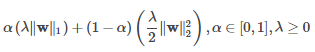

ElasticNetParam corresponds to α and regParam corresponds to λ. The default value for both is zero.

In [ ]:
plt.clf()
forest['Elevation'].hist()
%matplot plt

In [ ]:
import pyspark.ml.regression as rg

# let's predict elevation (first column) using the rest of features
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'Elevation']
    , outputCol='features')

#create a linear regression object and fit to dataset    
lr_obj = rg.LinearRegression(
    labelCol='Elevation',
    maxIter=10
    , regParam=0.01
    , elasticNetParam=1.00)
# lr_model = lr_obj.fit(elevation_dataset.to_spark())

#examine model coefficients
pip = Pipeline(stages=[vectorAssembler, lr_obj])

#run the pipeline
pModel = pip.fit(forest.to_spark())

In [ ]:
#get the trained model from the pipeline
lr_model = pModel.stages[-1]
#examine model coefficients
lr_model.coefficients

In [ ]:
summary = lr_model.summary

print(
    summary.r2
    , summary.rootMeanSquaredError
    , summary.meanAbsoluteError
)

In [ ]:
#get predictions from the model
(
    pModel.transform(forest.to_spark())
    .pandas_api()
    [['Elevation', 'prediction']]
    .head(5)
)

## Selecting the most predictable features

### Correlation matrix

In [ ]:
import pyspark.ml.stat as st
import pandas as pd

features_and_label = feat.VectorAssembler(
    inputCols=list(forest.columns)
    , outputCol='features'
)

corr = st.Correlation.corr(
    features_and_label.transform(forest.to_spark()), 
    'features', 
    'pearson'
)

corr_pd = corr.toPandas()
output_np = np.array(corr_pd.iloc[0, 0].values).reshape(
    (corr_pd.iloc[0, 0].numRows, corr_pd.iloc[0, 0].numCols))

corr_pd = pd.DataFrame(output_np, columns=forest.columns)
corr_pd.index = forest.columns
tril = np.tril(corr_pd)

fig, ax = plt.subplots()
plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.8, wspace=0.2, hspace=0.2)

cax = ax.matshow(tril, cmap='coolwarm_r')
fig.colorbar(cax)

plt.xticks(range(len(corr_pd.columns)), corr_pd.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr_pd.columns)), corr_pd.columns, fontsize=6)
%matplot plt

In [ ]:
#save the correlation matrix to S3
corr_pd = ps.from_pandas(corr_pd)
corr_pd.to_spark(index_col='index').repartition(1).pandas_api().to_csv('s3://gba6430-salehan-private/spark/tmp/corr')

### Univariate Feature Selector
is used for model selection. It selects a smaller subset of features which explain the dependent variable well.
* featureType categorical and labelType categorical, Spark uses `Chi-Squared`, i.e. Chi<sup>2</sup> in sklearn.
* featureType continuous and labelType categorical, Spark uses `ANOVA F-test`, i.e. f_classif in sklearn.
* featureType continuous and labelType continuous, Spark uses `F-value`, i.e. f_regression in sklearn.

In [ ]:
#exclude the label CoverType from features vector
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features'
)

#select top 10 features, store in a new column named selected
selector = feat.UnivariateFeatureSelector(
    labelCol='CoverType'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("categorical"
    ).setLabelType("categorical"
    ).setSelectionThreshold(10) #select top 10 features

pipeline_sel = Pipeline(stages=[vectorAssembler, selector])

model = (
    pipeline_sel
    .fit(forest.to_spark())
    .transform(forest.to_spark())
)

#print selected features
model.schema['selected'].metadata

In [ ]:
#display selected features as a dataframe
pd.DataFrame(model.schema['selected'].metadata['ml_attr']['attrs']['numeric'])

## Predicting forest coverage type
### Multinomial classification using binary classifiers, one vs the rest technique 
<img src='https://miro.medium.com/max/972/1*SwXHlCzh-d9UqHOglp3vcA.png' />  
<a href='https://medium.com/@b.terryjack/tips-and-tricks-for-multi-class-classification-c184ae1c8ffc'>Image source</a>

### Logistic regression

In [ ]:
#split into train and test sets
forest_train, forest_test = (
    forest.to_spark()
    .randomSplit([0.7, 0.3], seed=666)
)

#convert all features ti vector except for last column
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features'
)

#select top 10 predictors
selector = feat.UnivariateFeatureSelector(
    labelCol='CoverType'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("categorical"
    ).setLabelType("categorical"
    ).setSelectionThreshold(10) #select top 10 features

#create a multinomial regression object
#DV has 7 classes
logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , regParam=0.01
    , elasticNetParam=1.0
    , family='multinomial'
)

#create pipeline of 1)vector, 2)chisquare selector, 3)logistic regression
pipeline = Pipeline(
    stages=[
        vectorAssembler
        , selector
        , logReg_obj
    ])
#train the model
pModel = pipeline.fit(forest_train)

#### Check out the Logistic Regression object

In [ ]:
pModel.stages[-1]

#### Evaluating the Logistic Regression model

In [ ]:
import pyspark.ml.evaluation as ev

#apply the model to test set
logReg_model = (
    pModel
    .transform(forest_test)
)

results_logReg = logReg_model.select('CoverType', 'probability', 'prediction')

#evaluate performance of the multinomial model (7 classes)
evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    #F-1 score
    evaluator.evaluate(results_logReg)
    #weighted precision
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'weightedPrecision'}
    ) 
    #accuracy
    , evaluator.evaluate(
        results_logReg
        , {evaluator.metricName: 'accuracy'}
    )
)

#### Print selected features from chisquare selector

In [ ]:
%%pretty
selected_cols = ([x['name'] for x in logReg_model.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
pd.set_option('display.max_columns', 10)
ps.DataFrame(pModel.stages[-1].coefficientMatrix.toArray(), columns=selected_cols).to_spark().show(10)

### Ensemble Methods: Bagging VS Boosting
#### bagging
<img src='https://miro.medium.com/max/2000/1*_B5HX2whbTs3DS8M6YBD_w@2x.png'/>

#### Boosting 
<img src="https://miro.medium.com/max/2000/1*VGSoqefx3Rz5Pws6qpLwOQ@2x.png" />
<a href='https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205'>More information about ensemble methods</a>

Weighted measures are weighted based on the size of each class. Read about multinomial classification performance <a href='https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1'>here</a>.

### Random Forest classifier

In [ ]:
#same as previous, this time using Random Forest
rf_obj = cl.RandomForestClassifier(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)

pipeline = Pipeline(
    stages=[vectorAssembler, selector, rf_obj]
)

pModel = pipeline.fit(forest_train)

rf_obj_trained = (
    pModel
    .transform(forest_test)
)
results_rf = rf_obj_trained.select('CoverType', 'probability', 'prediction')

evaluator = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

(
    evaluator.evaluate(results_rf)
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'weightedPrecision'}
    )
    , evaluator.evaluate(
        results_rf
        , {evaluator.metricName: 'accuracy'}
    )
)

In [ ]:
#print selected features from chisquare selector
ps.DataFrame(rf_obj_trained.schema['selected'].metadata['ml_attr']['attrs']['numeric'])

In [ ]:
# display the feature importances
feature_importances = pModel.stages[-1].featureImportances
print("Feature Importances:")
for feature, importance in zip(forest_train.columns, feature_importances):
    print(feature, ": ", importance)

## Estimating forest elevation

### Random Forest regression

In [ ]:
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'Elevation']
    , outputCol='features')

#minInfoGain: min decrease in impurity to split
rf_obj = rg.RandomForestRegressor(
    labelCol='Elevation'
    , maxDepth=10
    , minInstancesPerNode=10
    , minInfoGain=0.1
    , numTrees=10
)

pip = Pipeline(stages=[vectorAssembler, rf_obj])

results = (
    pip
    .fit(forest.to_spark())
    .transform(forest.to_spark())
    .select('Elevation', 'prediction')
)

evaluator = ev.RegressionEvaluator(labelCol='Elevation')
evaluator.evaluate(results, {evaluator.metricName: 'r2'})

### Gradient Boosted Trees regression

In [ ]:
gbt_obj = rg.GBTRegressor(
    labelCol='Elevation'
    , minInstancesPerNode=10
    , minInfoGain=0.1
)

pip = Pipeline(stages=[vectorAssembler, gbt_obj])

results = (
    pip
    .fit(forest.to_spark())
    .transform(forest.to_spark())
    .select('Elevation', 'prediction')
)

evaluator = ev.RegressionEvaluator(labelCol='Elevation')
evaluator.evaluate(results, {evaluator.metricName: 'r2'})

## Clustering forest cover type

In [ ]:
import pyspark.ml.clustering as clust

#include all features except for the label
vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features')

norm = feat.StandardScaler(
    inputCol=vectorAssembler.getOutputCol()
    , outputCol='standardized'
    , withMean=True
    , withStd=True
)

#KMeans with k = 7
#set distance measure to euclidean or cosine
distance_measure = 'cosine'
kmeans_obj = clust.KMeans(k=7, 
                          seed=666, 
                          featuresCol=norm.getOutputCol(), 
                          distanceMeasure=distance_measure)

pip = Pipeline(stages=[vectorAssembler, norm, kmeans_obj])

In [ ]:
clustering_results = (
    pip
    .fit(forest.to_spark())
    .transform(forest.to_spark())
    .pandas_api()
)

clustering_results[['CoverType', 'prediction']].head(10)

* Calculate the Silhouette metric for clustering model  
* Silhouette ranges from −1 to +1  
* Anything around 0.5 or more indicates well separated clusters

In [ ]:
eval_distance_measure = 'squaredEuclidean' if distance_measure == 'euclidean' else distance_measure
clustering_ev = ev.ClusteringEvaluator(featuresCol=norm.getOutputCol(), distanceMeasure=eval_distance_measure)
clustering_ev.evaluate(clustering_results.to_spark())

### Visualizing Clusters

In [ ]:
clustering_results.prediction.value_counts()

In [ ]:
def cluster_scatter(df, x, y, color):
    plt.clf()
    ax = df.plot.scatter(x, y, c=color, colormap='viridis')
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'Clustering {x} vs {y}');
    return ax

In [ ]:
clusters_0_and_1 = clustering_results[clustering_results.prediction.isin([0,1])]
cluster_scatter(clusters_0_and_1, 'Elevation', 'Aspect', 'prediction')
%matplot plt

In [ ]:
clusters_3_and_1 = clustering_results[clustering_results.prediction.isin([3,1])]
cluster_scatter(clusters_3_and_1, 'Aspect', 'Slope', 'prediction')
%matplot plt

In [ ]:
clustering_results.groupby('prediction').agg({**{x:'mean' for x in ['Elevation', 'Aspect', 'Slope']}, 
                                              'features':'count'}).rename(
                                                {'features':'count'}, axis=1)

## Tuning hyper parameters

## Grid search
* Grid search allows us to test different values for hyper parameters, such as learning rate, regularization parameter, and elestic net parameter, and select the best values. Running the following cell will take several minutes.  
* Use divide and conquer to find the best values for hyperparameters. Start with something like this: [0, 0.25, 0.5, .75, 1]  
* Assuming that the best value is 0.75, you need to narrow down your search to [0.5, 1] range like this: [0.5, .6, .7, .8, .9, 1]  
* Assuming that the best value from previous step is 0.6, you should further narrow down the scope to [0.5, 0.7] range using the following: [.5, .54, .58, .62, .66, .7]

### Grid Search for Regularization Parameters

In [ ]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features')

selector = feat.UnivariateFeatureSelector(
    labelCol='CoverType'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("categorical"
    ).setLabelType("categorical"
    ).setSelectionThreshold(10) #select top 10 features

logReg_obj = cl.LogisticRegression(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , family='multinomial'
)


#use ParamGridBuilder to build a grid of parameters
logReg_grid = (
    tune.ParamGridBuilder()
    #try 4 values for regParam
    .addGrid(logReg_obj.regParam
            , [0.0, .25, 0.5, .75, 1] 
#              [.1,.2, .3, .4] #if the best in the first round is .25 then drill down
        )
    #try 4 values for elasticNetParam
    .addGrid(logReg_obj.elasticNetParam
            , [0.0, .25, 0.5, .75, 1] 
#              [.6,.7,.8] #if the best in the first round is .75 then drill down
        )
    .build()
)

logReg_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
        , labelCol='CoverType')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

logReg_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)

In [ ]:
print('Best params - regParam: {}, elasticNetParam: {}'.format(
    logReg_modelTest.bestModel._java_obj.getRegParam(),
      logReg_modelTest.bestModel._java_obj.getElasticNetParam()))

In [ ]:
import pandas as pd
tuning_results = pd.DataFrame([list(x.values()) for x in logReg_grid], columns=['regParam', 'elasticNetParam'])
tuning_results['F-1'] = logReg_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)

In [ ]:
# measure performance of best model
data_trans_test = data_trans.transform(forest_test)
results = logReg_modelTest.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'f1'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))

In [ ]:
%%pretty
selected_cols = ([x['name'] for x in data_trans_test.schema['selected'].metadata['ml_attr']['attrs']['numeric']])

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
pd.set_option('display.max_columns', 10)
ps.DataFrame(logReg_modelTest.bestModel.coefficientMatrix.toArray(), columns=selected_cols).to_spark().show(10)

In [ ]:
trainingSummary = logReg_modelTest.bestModel.summary
# Obtain the objective per iteration
objectiveHistory = trainingSummary.objectiveHistory
print("objectiveHistory:")
for objective in objectiveHistory:
    print(objective)

# for multiclass, we can inspect metrics on a per-label basis
print("False positive rate by label:")
for i, rate in enumerate(trainingSummary.falsePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("True positive rate by label:")
for i, rate in enumerate(trainingSummary.truePositiveRateByLabel):
    print("label %d: %s" % (i, rate))

print("Precision by label:")
for i, prec in enumerate(trainingSummary.precisionByLabel):
    print("label %d: %s" % (i, prec))

print("Recall by label:")
for i, rec in enumerate(trainingSummary.recallByLabel):
    print("label %d: %s" % (i, rec))

print("F-measure by label:")
for i, f in enumerate(trainingSummary.fMeasureByLabel()):
    print("label %d: %s" % (i, f))
    
accuracy = trainingSummary.accuracy
falsePositiveRate = trainingSummary.weightedFalsePositiveRate
truePositiveRate = trainingSummary.weightedTruePositiveRate
fMeasure = trainingSummary.weightedFMeasure()
precision = trainingSummary.weightedPrecision
recall = trainingSummary.weightedRecall
print("Accuracy: %s\nFPR: %s\nTPR: %s\nF-measure: %s\nPrecision: %s\nRecall: %s"
      % (accuracy, falsePositiveRate, truePositiveRate, fMeasure, precision, recall))

### Grid Search for Random Forest

In [ ]:
import pyspark.ml.tuning as tune

vectorAssembler = feat.VectorAssembler(
    inputCols=[x for x in forest.columns if x != 'CoverType']
    , outputCol='features')

selector = feat.UnivariateFeatureSelector(
    labelCol='CoverType'
    , outputCol='selected'
    , selectionMode = 'numTopFeatures'
    ).setFeatureType("categorical"
    ).setLabelType("categorical"
    ).setSelectionThreshold(10) #select top 10 features

rf_obj = cl.RandomForestClassifier(
    labelCol='CoverType'
    , featuresCol=selector.getOutputCol()
    , minInstancesPerNode=10
    , numTrees=10
)


#use ParamGridBuilder to build a grid of parameters
rf_grid = (
    tune.ParamGridBuilder()
    #try 4 values for minInstancesPerNode
    .addGrid(rf_obj.minInstancesPerNode
            , [5, 10, 20]
        )
    #try 4 values for maxDepth
    .addGrid(rf_obj.maxDepth
            , [10, 20]
        )
    .build()
)

rf_ev = ev.MulticlassClassificationEvaluator(
    predictionCol='prediction'
    , labelCol='CoverType')

# use K-fold cross validation for grid search
# CrossValidator binds all of these together
# default value is k=3
cross_v = tune.CrossValidator(
    estimator=rf_obj
    , estimatorParamMaps=rf_grid
    , evaluator=rf_ev
)

pipeline = Pipeline(stages=[vectorAssembler, selector])
data_trans = pipeline.fit(forest_train)

rf_modelTest = cross_v.fit(
    data_trans.transform(forest_train)
)

In [ ]:
print('Best params - MaxDepth: {}, MinInstancesPerNode: {}'.format(
    rf_modelTest.bestModel._java_obj.getMaxDepth(),
      rf_modelTest.bestModel._java_obj.getMinInstancesPerNode()))

In [ ]:
rf_grid

In [ ]:
[list(x.values()) for x in rf_grid]

In [ ]:
import pandas as pd
tuning_results = pd.DataFrame([list(x.values()) for x in rf_grid], columns=['minInstancesPerNode', 'maxDepth'])
tuning_results['F-1'] = rf_modelTest.avgMetrics
tuning_results.sort_values('F-1', ascending=False)

## Train-validation splitting
Instead of using k-fold cross validation, you can use a train-validation split approach. 

In [ ]:
train_v = tune.TrainValidationSplit(
    estimator=logReg_obj
    , estimatorParamMaps=logReg_grid
    , evaluator=logReg_ev
    , trainRatio=0.75
    #, parallelism=4
)

logReg_modelTrainV = (
    train_v
    .fit(data_trans.transform(forest_train)))

results = logReg_modelTrainV.transform(data_trans_test)

print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedPrecision'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'weightedRecall'}))
print(logReg_ev.evaluate(results, {logReg_ev.metricName: 'accuracy'}))
print('Best params, regParam: %s, elasticNetParam: %s' 
      %(logReg_modelTrainV.bestModel._java_obj.getRegParam(),
      logReg_modelTrainV.bestModel._java_obj.getElasticNetParam()))

In [ ]:
#print selected features from chisquare selector
print(results.schema['selected'].metadata)

#print model coefficients
#for a binomial model use coefficients instead of coefficientMatrix
logReg_modelTrainV.bestModel.coefficientMatrix.toArray()